<a href="https://colab.research.google.com/github/juancn95/saturdaysAI_titanic_challenge/blob/pdt_1/SaturdaysAI_titanic_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **El desafío del Titanic**
---

## **Visión general**
El hundimiento del Titanic es uno de los naufragios más infames de la historia. El 15 de abril de 1992, durante su viaje de inauguración, el considerado "no hundible" RMS Titanic, se hundió luego de colisionar con un iceberg. Desafortunadamente, no hubieron suficientes salvavidas para cada uno de los pasajeros a bordo, resultando en la muerte de más de 1502 personas, entre pasajeros y tripulación, para un total de 2224. 

Aunque habían elementos de buena suerte involucrados en la supervivencia, parece que ciertos grupos de personas tuvieron mayor probabilidad de sobrevivir que otras. 

En esta competencia, usando los datos de los pasajeros, tales como nombre, género, clase socio-económica, entre otros; se deberá construir un modelo predictivo que responda a la siguiente pregunta: ¿Cuáles fueron los grupos de personas con mayor probabilidad de sobrevivir? 

## **Objetivo**
- Predecir si cada uno de los pasajeros sobrevivió (1) o  no (0), tras el hundimiento del barco Titanic

## **Métrica**

La puntuación del modelo será el **porcentaje de pasajeros correctamente predecidos**, conocido también como **precisión**.

## **Formato del archivo de entrega**
El formato será un archivo de extensión `.csv` con 418 entradas con su correspondiente fila de encabezado, y solo deberá contener las columnas `PassengerID` y `Survived`. Si el archivo tiene una columna o fila extra, se remitirá un error. 

`PassengerID`: Ordenado en cualquier orden, sea ascendente o descendente. 

`Survived`: Contiene la **predicción binaria**: 1 para sobrevivió, 0 para fallecido.



# **Inicio**

## **Depencias**
**Manipulación de datos**: `pandas` `numpy` `scikit-learn`

**Visualización de datos**: `matplotlib` `seaborn` `cmocean`

**Estadística**: `phik`<font size="2"><sup>1</sup></font> `scipy`

**Optimización:** `itertools` `re`

**Redes neuronales:** `tensorflow` `keras`

<font size="2"><b>[Phik](https://arxiv.org/abs/1811.11440) </b>
<sup>1</sup> es un coeficiente de correlación basado en varios refinamientos a la prueba de hipótesis de Pearson de independencia de dos variables: categóricas, ordinales y de intervalo.</font>

In [655]:
!pip install phik
! pip3 install -U cmocean

Requirement already up-to-date: cmocean in /usr/local/lib/python3.6/dist-packages (2.0)


In [0]:
# Análisis
import pandas as pd
import numpy as np

# Visualización
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import cmocean.cm as cmo

#Preparación
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#Optimización
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
import re

#Redes neuronales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam, SGD

# Estadística
import phik
from phik import resources, report
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from scipy import stats
from scipy.stats import chi2, chi2_contingency
from math import sqrt


**Carga de datos desde AWS**


In [0]:
#Carga de datos a dataframes
df_train = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/train.csv')
df_test = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/test.csv')
df_sub = pd.read_csv('https://saturday-ai.s3-sa-east-1.amazonaws.com/titanic/gender_submission.csv')

**Pre-configuración de gráficos**

In [0]:
title = {'fontsize': 11, 'weight': 'bold'}
labels = {'fontsize': 10, 'weight': 'normal'}
ticks = {'fontsize': 8, 'weight': 'normal'}

# **Análisis exploratorio de los datos**

La siguienta Tabla, brinda una breve descripción de los datos en función de la información proporcionada por Kaggle, y será un punto de partida para nuestro **Análisis Exploratorio de Datos**.  

Variable | Definición | Valor 
--- | --- | --- 
`PassengerId` | Identificador
`Survived` | Supervivencia | 0: No, 1 : Sí 
`Pclass` | Clase de boleto | 1: 1st, 2: 2nd, 3: 3rd
`Name` | Nombre del pasajero 
`Sex` | Género | Male, Female 
`Age` | Edad | |
`SibSp` | No. hermanos o parejas a abordo
`Parch` | No. de padres o hijos a abordo |
`Ticket` | Número del ticket|| Cadena |
`Fare` | Tarifa del pasajero continuos |
`Cabin` | Número de cabina o compartimento string |
`Embarked` | Puerto de embarque | C: Cherbourg, Q: Queenstown, S: Southampton 

## **Identificación de variables**
Para poder visualizar una pequeña porción del conjunto de datos $N$, usaremos los métodos `.head` y `.tail` para imprimir las primeras y últimas 10 observaciones.

In [659]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [660]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [661]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [662]:
df_test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [663]:
df_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [664]:
df_sub.tail()

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


In [665]:
print('Conjunto de entrenamiento: {} observaciones y {} características'.format(df_train.shape[0], df_train.shape[1]))
print('Conjunto de testeo: {} observaciones y {} características'.format(df_test.shape[0], df_test.shape[1]))
print('Conjunto total: {} observaciones y {} características'.format(df_train.shape[0] + df_test.shape[0], df_train.shape[1]))

Conjunto de entrenamiento: 891 observaciones y 12 características
Conjunto de testeo: 418 observaciones y 11 características
Conjunto total: 1309 observaciones y 12 características


Eventualmente, se necesitará aplicar operaciones sobre cada característica del conjunto de entrenamiento, esto involucraría tener las mismas características sobre el conjunto de tes, por tanto será necesario agruparlos para aplicar las reglas en común.

In [0]:
df2 = pd.merge(df_test, df_sub)
df = df_train.append(df2, ignore_index=True)

Variable | Tipo de variable | Tipo de dato | Categoría
--- |  --- | --- |--- | 
`PassengerId`| | ? | ?  
`Survived` | Predictiva | Cualitativo | Nominal (Dicotómico)
`Pclass` | Explicativa | Cualitativo | Ordinal 
`Name` | ? | ? | Nominal 
`Sex` | Explicativa | Cualitativo | Nominal (Dicotómica) 
`Age` | Explicativa | Cuantitativo | Continuo 
`SibSp` | ? | Cuantitativo | Discreto 
`Parch` | ? | Cuantitativa | Discreto 
`Ticket` | ? | Cualitativo | Categórica 
`Fare` | ? | Cuantitiva | Continuo 
`Cabin` | ? | Cualitativo | Nominal
`Embarked` | ? | Cualitativo | Nominal 

El **?** representa falta de certeza para determinar el tipo o categoría de la variable. 

# **Paquete de trabajo No. 1**

**Entregable**
* Objeto `DataFrame` con los pares de variables asignados **mejorados**
---
<p>
<font size="2.2">
<b>Nota:</b> Este entrable debe tener como fin, incrementar la relevancia, como sea posible, de todos los pares de variables con respecto a la variable predictiva.<font>
</p>
<p>
<font size="2.2">
<b>Claves:</b>La métrica usada para cuantificar la correlación o relación entre dos pares de variables dependerá su tipo, sea continuo-continuo, categórico-categórico o categórico-continuo.<font>
</p>



## **nameSex**

In [0]:
# Escriba el código del par de variables 'nameSex' aquí

## **sexAge**

In [0]:
# Escriba el código del par de variables 'sexAge' aquí

## **pclassFareEmbarked**

In [0]:
# Escriba el código del par de variables 'pclassFareEmbarked' aquí

## **pclassTicketCabin**

In [0]:
# Escriba el código del par de variables 'pclassTicketCabin' aquí


## **sibspParch**

In [0]:
# 0 = No sobrevive, 1 = Sobrevive
x0 = df.loc[df.Survived == 0, 'SibSp']
x1 = df.loc[df.Survived == 1, 'SibSp']

y0 = df.loc[df.Survived == 0, 'Parch']
y1 = df.loc[df.Survived == 1, 'Parch']

**¿Hay ausencia de valores o nulos en los pares de variables para ambas categorías?**

In [672]:
null_sum = [x0.isnull().sum(), x1.isnull().sum(), y0.isnull().sum(), y1.isnull().sum()]
count = [x0.count(), x1.count(), y0.count(), y1.count()]

for i, j in zip(null_sum, count):
  print('{} valores nulos en {} observaciones del subconjunto'.format(i, j))

0 valores nulos en 815 observaciones del subconjunto
0 valores nulos en 494 observaciones del subconjunto
0 valores nulos en 815 observaciones del subconjunto
0 valores nulos en 494 observaciones del subconjunto


Al momento, se puede observar una proporción igual en la partición fel par de variables para ambas categorías. 

**Planteamiento: ¿Cuáles son los patrones que hay dentro de cada categoría?**

Considerando la naturaleza discreta de los datos, procederemos a realizar un análisis gráfico para observar la proporción relativa (en %) de cada valor único por cada categoría. 

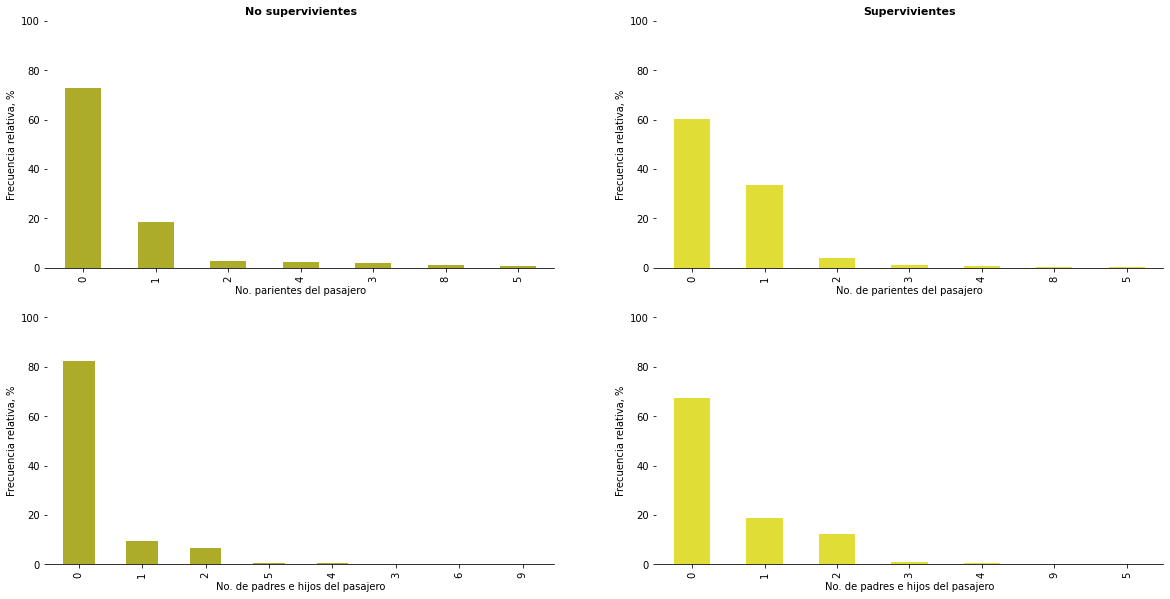

In [673]:
# Creamos un objeto de subplots y establecemos la estructura

fig = plt.figure(figsize=(20,10))

fig.add_subplot(221)
sibsp_m = (100 * x0.value_counts() / len(x0))
ax = sibsp_m.plot.bar(color = '#ADAB2A')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('No supervivientes', **title)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. parientes del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(222)
sibsp_v = (100 * x1.value_counts() / len(x1))
ax = sibsp_v.plot(kind = 'bar', color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('Supervivientes', **title)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de parientes del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(223)
parch_m = (100 * y0.value_counts() / len(y0))
ax = parch_m.plot.bar(color = '#ADAB2A') 
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de padres e hijos del pasajero', **labels)
ax.set_ylim(0, 100)

fig.add_subplot(224)
parch_v = (100 * y1.value_counts() / len(y1))
ax = parch_v.plot(kind = 'bar', color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_ylabel('Frecuencia relativa, %', **labels)
ax.set_xlabel('No. de padres e hijos del pasajero', **labels)
ax.set_ylim(0, 100)

plt.show()

Se observa una proporción muy alta de valores 0 sobre el par de variables, y para ambas categorías. 

**Planteamiento: ¿Habían más solteros que pasajeros con familia en Titanic?**

Crearemos una nueva característica sobre el conjunto de datos que represente el número de familiares o familia del pasajero y observaremos el comportamiento de la variable

In [0]:
df.loc[pd.notnull(df['SibSp']), 'Family'] = df['SibSp'] + df['Parch']

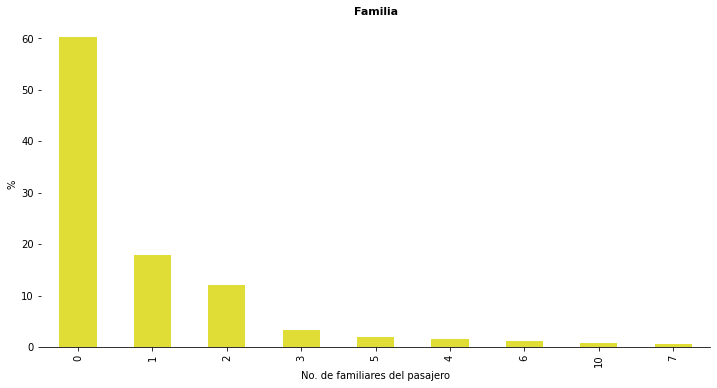

In [675]:
fam = df.Family.value_counts()
fam = 100 * fam / len(df)
ax = fam.plot.bar(figsize=(12, 6), color ='#E0DE36')
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)
ax.set_title('Familia', **title)
ax.set_ylabel('%', **labels)
ax.set_xlabel('No. de familiares del pasajero', **labels)
plt.show()

Efectivamente, la proporción de pasajeros "*solteros*" o sin parientes era mucho mayor que aquella que tenía algún familiar a bordo, decrementando dicha proporción mientras mayor era el número de familiares.

# **Tratamiento de valores nulos**

Se parte con un conjunto de datos $N$ con $n: 1727$ observaciones y $p: 12$ características. 
Con el método `isnull` observaremos cuáles son las características con valores faltantes o nulos.

In [676]:
df.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Family            0
dtype: int64

Se observa que la proporción de nulos en los conjuntos de entrenamiento y testeo, así como sus subconjuntos $H$ y $M$, respectivamente, satisfacen la siguiente inecuación: 

$Cabin > Age > Embarked > Fare $ 


**Visualización**

Para ver la distribución de los valores nulos sobre la población de estudio, utilizaremos una gráfica de barras verticales, y observaremos como se comporta la proporción en función del género. 

In [0]:
def barh(data, query, size):
  """"
  Función que permite graficar barras verticales y comparar entre la población en función del género.
  Esta gráfica está pensada solo para comparar en función del género (variable de segregación) y requiere que esta variable
  se haya codificado como 0: hombre, 1: mujer.  
  """

  segregation = 'Sex'

  fig = plt.figure(figsize=size)

  fig.add_subplot('311')

  g = 100 * data[query].isnull().sum() / len(data)
  # Se calcula los valores nulos como proporción relativa
  # y se crea el gráfico utilizando la funcionalidad de pandas
  ax = g.plot.barh(**{'cmap': cmo.thermal})
  # Se almacena el índice del gráfico actual y se configuran algunos de sus parámetros 
  ax.set_title('% valores nulos en población total', loc='left', **title)
  ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
  ax.set_yticklabels([query[0], query[1]])
  ax.set_xlim(0, 100)
  # Bucle para deshabilitar los spines del gráfico
  spines_off = ['top', 'bottom', 'right']
  for s in spines_off:
    ax.spines[s].set_visible(False)
  # Bucle para añadir la etiqueta alado de la barra
  for k, p in enumerate(g):
    ax.text(p + 1, k, '{}%'.format(int(p)), color= '#8C8C8C', **labels)
  # Bucle para graficar los subplots, se sigue el mismo procedimiento
  for ix, value in enumerate(data[segregation].unique()):

    fig.add_subplot('31' + str(ix+2))

    g = 100 * data.loc[data[segregation] == value, query].isnull().sum() / len(data)
    ax = g.plot.barh(**{'cmap': cmo.thermal})
    gender = {'male': 'hombres', 'female': 'mujeres'}
    #gender = {0: 'hombres', 1: 'mujeres'}
    ax.set_title('% valores nulos en población de {}'.format(gender[value]), loc='left', **title)
    ax.set_xlim(0, 100)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.set_yticklabels([query[0], query[1]])

    spines_off = ['top', 'bottom', 'right']
    for s in spines_off:
      ax.spines[s].set_visible(False)
  
    for k, p in enumerate(g):
      ax.text(p + 1, k, '{}%'.format(int(p)), color= '#8C8C8C', **labels)
  
  plt.show()

Conjunto de entrenamiento


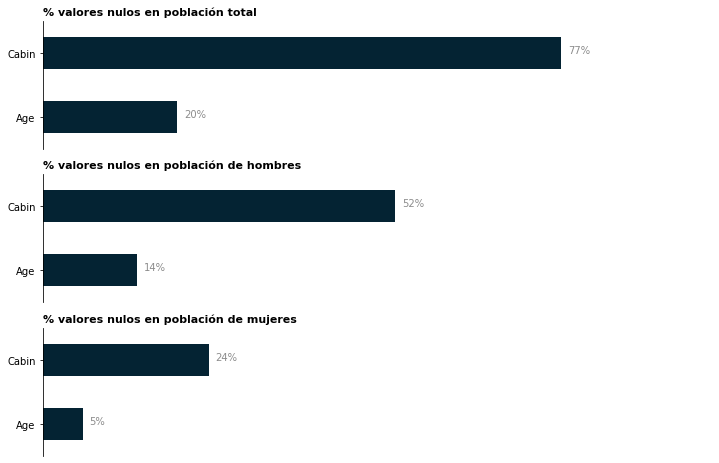

Conjunto de testeo


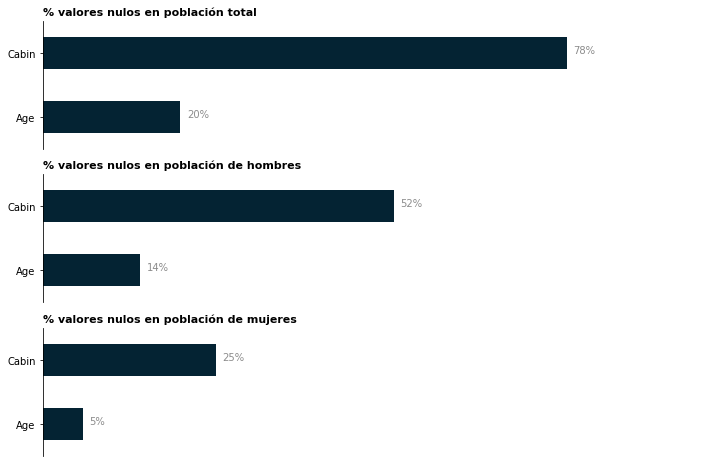

In [678]:
print('Conjunto de entrenamiento')
barh(df, query=['Age', 'Cabin'], size=(12, 8))
print('Conjunto de testeo')
barh(df2, query=['Age', 'Cabin'], size=(12, 8))

Se observa que la proporción de nulos en los conjuntos de entrenamiento y testeo, así como sus subconjuntos $H$ y $M$, respectivamente, satisfacen la siguiente inecuación: 

$Cabin > Age $

Es decir, hay un número mayor de observaciones nulas en la variable `Cabin` que en `Age`.

## **Una retrospectiva sobre Cabin**

**¿Como se distribuían las cabinas en el Titanic?**

![Plano Transversal del Titanic](https://upload.wikimedia.org/wikipedia/commons/8/84/Titanic_cutaway_diagram.png)

En esta gráfica de vista transversal, se puede observar de forma clara la distribución de los compartimentos del Titanic. La leyenda, muestra 7  categorías que distribuidas desde arriba hacia abajo.



**¿Cuáles son las categorías presentes en nuestro conjunto de datos?**

Antes de solventar esta pregunta, vamos a extraer una muestra aleatoria de la variable `Cabin` para conocer más sobre la misma. 

In [679]:
df.Cabin.sample(20)

35                  NaN
291                 B49
1205                C32
860                 NaN
1023                NaN
1269                C39
1051                NaN
915     B57 B59 B63 B66
965                C130
818                 NaN
873                 NaN
995                 NaN
1010                NaN
1143                C89
711                C124
804                 NaN
897                 NaN
218                 D15
692                 NaN
761                 NaN
Name: Cabin, dtype: object

`Cabin`, muestra naturaleza categórica nominal, y se compone de una letra y un número asociado, posiblemente indicando la sección en la que se encuentra el compartimento ocupado por el pasajero. 
Vale entonces preguntar: ¿Cuántos compartimentos puede tener un pasajero?

In [680]:
col = []
for ix, value in df.Cabin.items():
  try:
    m = re.findall('[A-Z]', value)
    col.append(len(m))
  except:
    pass

max(col)

4

Según el resultado obtenido, el número máximo de compartimentos asociados a un solo pasajero es 4, no obstante esto solo permite conocer el $n$ compartimentos ocupados sin distinguir si estos se encuentran en la misma sección o no. También, debemos saber cómo se distribuyen los compartimentos en función del estrato socieconómico. Para esto, se requiere separar la letra de cada valor y llamaremos a la nueva variable: `Deck`.

In [681]:
df.loc[pd.notnull(df['Cabin']), 'Deck'] = df['Cabin'].str[0]
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Deck
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,4,B
752,753,0,3,"Vande Velde, Mr. Johannes Joseph",male,33.0,0,0,345780,9.5000,NaN,S,0,NaN
1274,1275,1,3,"McNamee, Mrs. Neal (Eileen O'Leary)",female,19.0,1,0,376566,16.1000,NaN,S,1,NaN
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C,1,NaN
323,324,1,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.0000,NaN,S,2,NaN


Luego de haber realizado la operación, visualizaremos a través de una gráfica de barras verticales dicha distribución antes cuestionada. 

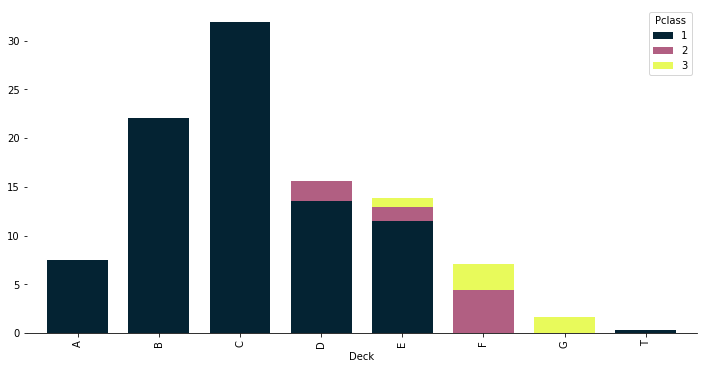

In [682]:
pclass = df.groupby(['Deck', 'Pclass']).count().unstack().PassengerId 
pclass = pclass / pclass.sum().sum() * 100
ax  = pclass.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

In [683]:
pclass.T

Deck,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,7.457627,22.033898,31.864407,13.559322,11.525424,NaN,NaN,0.338983
2,NaN,NaN,NaN,2.033898,1.355932,4.406780,NaN,NaN
3,NaN,NaN,NaN,NaN,1.016949,2.711864,1.694915,NaN


La gráfica muestra una clara distribución de los pasajeros de primera clase, y según lo obtenido, estos ocuparon alrededor del 87% de cuartos disponibles, y se distribuyeron en las cabinas **A**, **B** y **C**. Solo en la **E**, se encontramos los tres estratos. Por otro lado, los pasajeros de segunda y tercera clase, que ocuparon el 13% restante de habitaciones, se distribuyeron en las cabinas como sigue: **D**, **E**, **F** y **G**. Por último, hay una última categoría **T**, y representa apenas el 0.3%. ¿Quiénes han ocupado esta cabina? 


In [684]:
df.loc[df.Deck == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Deck
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,0,T


Al parecer, es una única persona y su nombre es *Stephen Weart Blackwell*, de 45 años, partió desde Southampton y abordó la primera clase con una tarifa de $35.5. A continuación, observemos cuál es la tarifa promedio de la primera clase. 

In [685]:
print('Tarifa mediana: {}'.format(df.loc[df.Pclass == 1, 'Fare'].median()))
print('Tarifa promedio: {}'.format(df.loc[df.Pclass == 1, 'Fare'].mean()))
print('Moda de la tarifa: {}'.format(df.loc[df.Pclass == 1, 'Fare'].mode()[0]))

Tarifa mediana: 60.0
Tarifa promedio: 87.5089916408668
Moda de la tarifa: 26.55


Cabe notar que su tarifa estaba por debajo de la media, ¿Quién era él? Por último, observaremos la distribución de las cabinas en función del género y supervivencia: ¿Existirá alguna relación? 

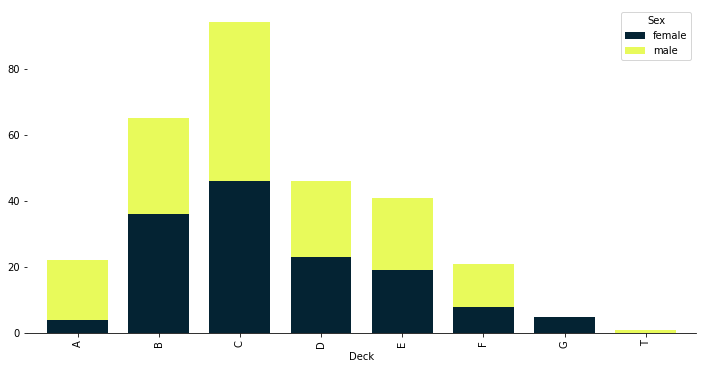

In [686]:
ax = df.groupby(['Deck', 'Sex']).count().unstack().PassengerId.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

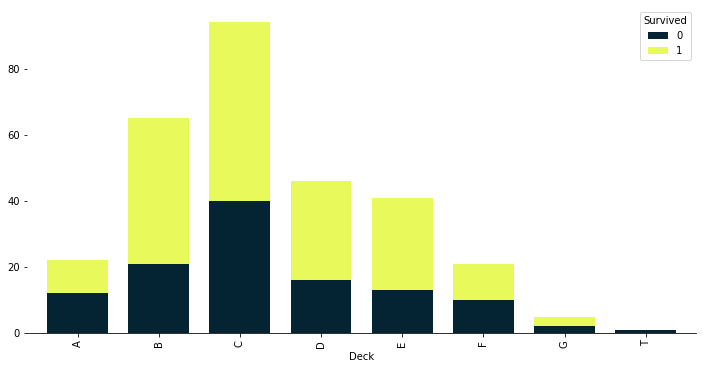

In [687]:
ax = df.groupby(['Deck', 'Survived']).count().unstack().PassengerId.plot.bar(stacked=True, figsize=(12, 6), width=0.75, **{'cmap': cmo.thermal})
spines_off = ['left', 'top', 'right']
for s in spines_off:
  ax.spines[s].set_visible(False)

Sin más, se puede observar un patrón entre la forma en cómo las mujeres se distribuyeron a lo largo de los distintos compartimentos y su garantía de sobrevivir, al parecer podría jugar un rol en la supervivencia pero no podemos asumir sin antes comprobarlo estadísticamente. 

# **Creación de variables derivadas**

En este apartado, dedicaremos esfuerzos a derivar variables que aporten explicabilidad al contexto del problema.

**Variable derivada del abreviado del género o título**

Aunque el nombre tenga naturaleza nominal y no sea operable, en ciertas ocasiones puede aportar información a través de los abreviados de género o título, básicamente estos son los términos en segunda persona que reemplazan al sustantivo y aportan información del tipo de género, edad, status o nivel de educación.

In [688]:
df["Title"] = df.Name.str.replace('(.*, )|(\\..*)', '')
df['Title'] = df['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})
df['Title'].value_counts()

Mr              757
Miss            264
Mrs             198
Master           61
Dr                8
Rev               8
Col               4
Major             2
Sir               1
Lady              1
the Countess      1
Capt              1
Don               1
Dona              1
Jonkheer          1
Name: Title, dtype: int64

Observamos que existen pocos valores en clases distintas, por tanto procedemos a agruparlos, pero antes daremos una visualización de correlación a nuestro conjunto de datos. 

## **Usando Phik para obtener una matriz de correlación de variables mixtas**

A menudo los análisis de correlación requerieren de un entendimiento exhaustivo de cada par de variable, con el fin de poder seleccionar la métrica de tamaño de efecto adecuada. Por ejemplo:

* Cuando el par de variables es de naturaleza continuo-continuo: Pearson's R.
* Cuando el par de variables es de naturaleza continuo-categórico: Correlation Ratio.
* Cuando el par de variables es de naturaleza categórico-categóric: Cramer's V or Theil's U.

Para abordar esta problemática, considerando la mixtura de tipos de variables presentes en el conjunto de datos del Titanic, se opta por usar Phik. 

**Definición de la categoría de cada variable**

In [689]:
query = ['Survived', 'Pclass', 'Sex', 'Fare', 'Age', 'Family', 'Embarked', 'Deck', 'Title']
data = df[query]
data_types = {'Survived': 'categorical',
             'Pclass':'ordinal',
             'Sex':'categorical',
             'SibSp':'interval',
             'Parch':'interval',
             'Fare':'interval',
              'Age': 'interval',
             'Embarked':'categorical',
             'Family':'interval',
              'Deck': 'categorical',
              'Abv': 'categorical'}

interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
interval_cols

['Fare', 'Age', 'Family']

**Creación de bines para las variables de intervalo**

In [690]:
data_binned, binning_dict = bin_data(data, cols=interval_cols, retbins=True, bins=8)

/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 320.20575 - 384.2469
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 384.2469 - 448.28805
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 7.499999999999998 - 8.749999999999998
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))


**Visualización de matriz de correlacción**

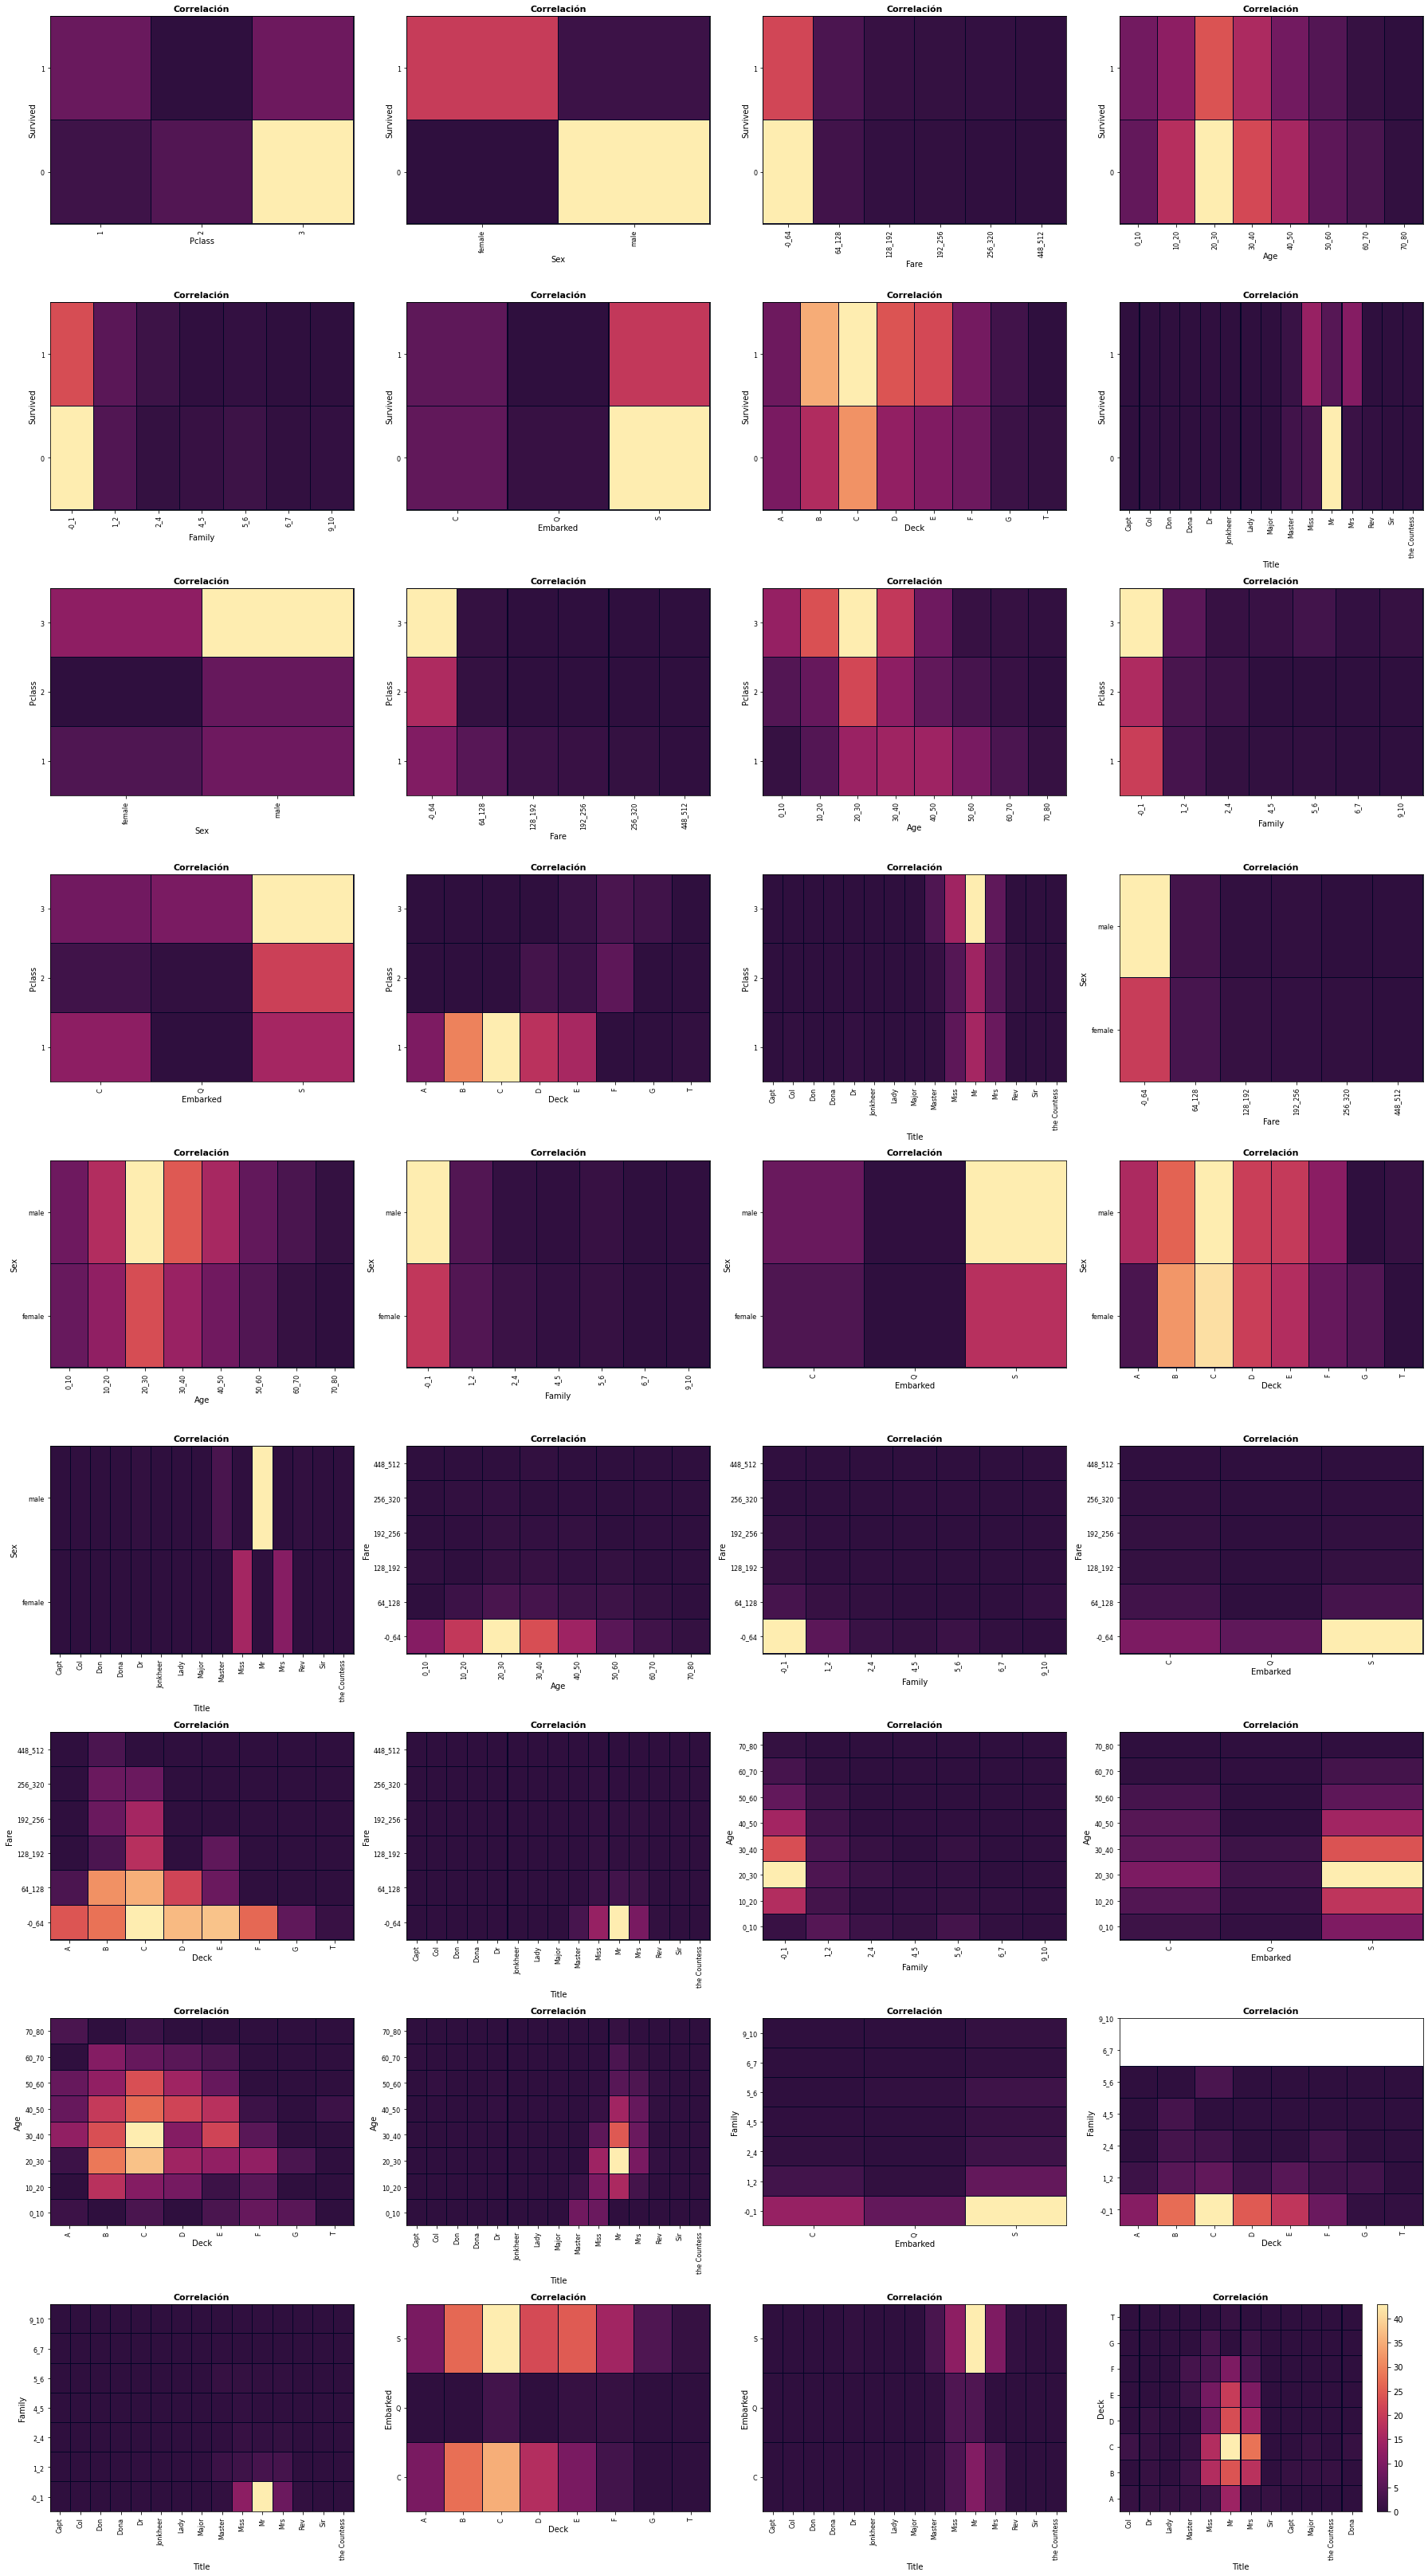

In [691]:
plt.rc('text', usetex=False)

n=0
for i in range(len(data.columns)):
    n+=i
    
ncols=4
nrows=int(np.ceil(n/ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(25,5*nrows))
ndecimals = 0

for i, comb in enumerate(itertools.combinations(data_binned.columns.values, 2)):
    
    c = int(i%ncols)
    r = int((i-c)/ncols )

    # datos
    c0, c1 = comb
    datahist = data_binned.groupby([c0,c1])[c0].count().to_frame().unstack().fillna(0)
    datahist.columns = datahist.columns.droplevel()
    
    # gráfico
    img = axes[r][c].pcolormesh(datahist.values, linewidth=0.005, edgecolors='#030526',  **{'cmap': cmo.matter_r})
    
    # etiquetas de sticks
    if c0 in binning_dict.keys():
        ylabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c0][i][0], binning_dict[c0][i][1])
                   for i in range(len(binning_dict[c0]))]
    else:
        ylabels = datahist.index

    if c1 in binning_dict.keys():        
        xlabels = ['{1:.{0}f}_{2:.{0}f}'.format(ndecimals, binning_dict[c1][i][0], binning_dict[c1][i][1])
                    for i in range(len(binning_dict[c1]))]
    else:
        xlabels = datahist.columns
    
    # etiquetas del eje
    axes[r][c].set_yticks(np.arange(len(ylabels)) + 0.5)
    axes[r][c].set_xticks(np.arange(len(xlabels)) + 0.5)
    axes[r][c].set_xticklabels(xlabels, rotation='vertical', **ticks)
    axes[r][c].set_yticklabels(ylabels, rotation='horizontal', **ticks)    
    axes[r][c].set_xlabel(datahist.columns.name, **labels)
    axes[r][c].set_ylabel(datahist.index.name, **labels)    
    axes[r][c].set_title('Correlación', **title)
    
fig.colorbar(img)

plt.tight_layout()


**Claves para Deck en función de los valores obtenidos por correlación**:
- Family

Es más probable que siendo soltero (Family: 0),  ocupes el compartimento C, seguido del B o D. 
- Age 

Si ocupas el compartimento B, es más probable que tengas entre 30-40 años, seguido de 20-30 y 40-50, respectivamente.
Si ocupas el compartimento B, es más seguro que tengas entre 20-30, seguido de 30-40 y 10-20, respectivamente. 
- Survived

Es más probable que de si el pasajero sobrevivió y era de género femenino, ocupara el compartimento C, seguido del B y D. 

**Claves para Title en función de los valores obtenidos por correlación**:

- Se observa zonas de mayor correlación para los pronombres Miss, Mister y Mrs, tanto si de supervivencia se trata así como de clase económica. 


In [692]:
# Agrupamos en menos categorias
df['Title'] = df['Title'].replace({'Lady':'Miss','Dona':'Miss'})
df['Title'] = df['Title'].replace(['Sir', 'Master', 'Don', 'Jonkheer', 'the Countess', 'Dr', 'Rev','Col','Major','Capt'], 'Others')
df['Title'].value_counts()

Mr        757
Miss      266
Mrs       198
Others     88
Name: Title, dtype: int64

**¿Cuáles serían las mejores variables para el llenado de valores nulos sobre Deck?**

/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 307.39752 - 358.63044
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 358.63044 - 409.86336
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 409.86336 - 461.09628
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
/usr/local/lib/python3.6/dist-packages/phik/binning.py:68: UserWarning: Empty bin with bin-edges 7.999999999999999 - 9.0
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))


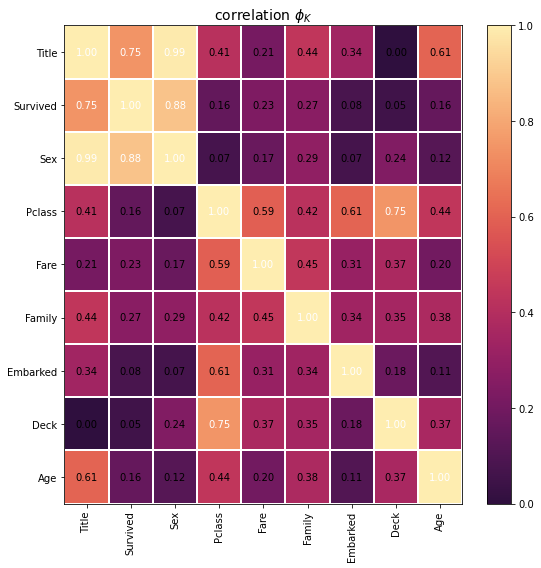

In [693]:
phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map=cmo.matter_r, title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(8,8))
plt.tight_layout()

De acuerdo con la matriz de correlación global, el nivel socioeconómico es la variable idónea, en este caso utilizaremos la moda para llenar los valores vacíos. 

In [694]:
for i in df.Pclass.unique():
  print('Clase {}: ; Moda: {}'.format(i, df.loc[df.Pclass == i, 'Deck'].mode()))

Clase 3: ; Moda: 0    F
dtype: object
Clase 1: ; Moda: 0    C
dtype: object
Clase 2: ; Moda: 0    F
dtype: object


In [722]:
df = df[df['Pclass'] == 1].fillna({'Deck': 'C'})
df.fillna({'Deck': 'F'})

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Deck,Title
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C,Mrs
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C,Mrs
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,E,Mr
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0,C,Miss
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S,0,A,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1295,0,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S,0,C,Mr
1295,1296,0,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C,1,D,Mr
1298,1299,0,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,2,C,Mr
1302,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,1,C,Mrs


In [0]:
prueba = df.copy()

In [0]:
df = pd.get_dummies(prueba, columns=['Sex', 'Title', 'Embarked', 'Deck'])

In [735]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Family,Sex_female,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Others,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_T
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0
11,12,1,1,"Bonnell, Miss. Elizabeth",58.0,0,0,113783,26.5500,C103,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0
23,24,1,1,"Sloper, Mr. William Thompson",28.0,0,0,113788,35.5000,A6,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,1295,0,1,"Carrau, Mr. Jose Pedro",17.0,0,0,113059,47.1000,NaN,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
1295,1296,0,1,"Frauenthal, Mr. Isaac Gerald",43.0,1,0,17765,27.7208,D40,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0
1298,1299,0,1,"Widener, Mr. George Dunton",50.0,1,1,113503,211.5000,C80,2,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0
1302,1303,1,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",37.0,1,0,19928,90.0000,C78,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


## **Usando el método tradicional para analizar la correlación bivariante**

**Planteamiento de la hipótesis nula:** 

El fin del análisis bi-variante es poder resolver la duda de: ¿Existe alguna relación entre una variable $X$ y la supervivencia? 

**$H_{o}:$** No hay dependencia entre las 2 variables categóricas.

**$H_{a}:$** Hay dependencia entre las 2 variables categóricas.

### **Sexo-Superviviencia**

In [0]:
chi_sq = df.Sex.replace({'male': 0, 'female': 1}, inplace=True)

In [0]:
chi_sq = df[['Sex', 'Survived']]

**Paso 1:** Obtener la tabla de contigencia con la función `.crosstab` de `Pandas`.

In [0]:
# Frecuencias observaciones
obs = pd.crosstab(chi_sq.Sex , chi_sq.Survived)

#Chi2, p-valor, grados de libertad, frecuencia esperada
chi_2, p, dof, ex = chi2_contingency(obs)

print('Valor de ji-cuadrado: {}'.format(round(chi_2, 2)))
print('p-valor: {}'.format(p))
print('Grados de libertad: {}'.format(dof))
print('Frecuencia esperada de las observaciones: \n{}'.format(ex.round(2)))

alpha = 0.01 # p-value
cv = chi2.ppf(q= 1-alpha, df= dof)
print('Valor crítico o probabilidad menor de la cola:', cv)

print('Test de independencia entre variables')
if chi_2 >= cv:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas.')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

print('\nTest de significación')
if p <= alpha:
  print('- Se rechaza Ho, existe relación entre las 2 variables categóricas')
else:
  print('- Se retiene Ho, no existe relación entre las 2 variables categóricas')

In [0]:
def cramers_v(x, y):

  obs = pd.crosstab(x,y)
  chi, p, dof, ex = chi2_contingency(obs)
  n = obs.values.sum()
  r, k = obs.shape
  phi2 = chi / n
  phi2corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
  rcorr = r - ((r-1)**2 / (n-1))
  kcorr = k - ((k-1)**2 / (n-1))
  
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [0]:
cramers_v(df.Sex, df.Survived)

In [0]:
tau, p = stats.kendalltau(df.Sex, df.Survived)

print('Valor de Kendall Tau-b: {}'.format(round(tau, 2)))
print('p-valor: {}'.format(p))

In [0]:
# Agrupamos en menos categorias
df['Title'] = df['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')
df['Title'] = df['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')
df['Title'].value_counts()